# Tutorial for training your own GPT model on any dataset you like!

# First things first - Data
The data we will use for this tutorial will be Elon Musk Tweets, which contains around 40k lines of tweets.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/elon_tweets_clean.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  3855104


In [ ]:
# let's look at the first 1000 characters
print(text[:1000])

 if he doesn't keep his word it makes him a democrat. he is not going to go on a soul searching endless vacation like jack. whomever he gets as ceo, will run it as elon has established. division is caused enough by fake gopers.
 if they speak truth and present facts they have no need to worry about being banned 
 iterators. i have one in my kitchen sink. all it does is regurgitate chum and garbage.
 he's in the cnn recording studio with a sotu background trying to look convincing.
 soyuz ms-22 capsule is leaking coolant 
 these guys ain't innocent. 
 sense when do media platforms run our country and our rights? democrats are nothing more than people that want to control you. yeah fuck that.
 someone needs to them that!!!!!!
 join - a project created to support disadvantaged kids, celebrate the holiday in crypto space and to profit all investors prepare yourself for being part of the greatest and most rewarding xmas token! 
 elon i believe we can change the world for the better i’m tell

In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !#$%'()*+,-./0123456789:;<=>?@[\]^_`abcdefghijklmnopqrstuvwxyz{|}~¡£§©«®¯°´·¹»¿×àáâäæéêëìíïðñòóöúûüāăąğīįıōśəɡʖˈˌ˶̇͜͡πвопртяёђџґӿ،اترسهويِپښ۱۴۸۹धनफमरविॉो्૮ขงจชณตทนบผยลวสหอัาืุโ่༝აḿ​‌‑–—―‘’“”„•…‼⁉€₹⃣ℎ™↑→↓√≠⋆⌨⏬⏰⏱⏲⏳
214


Now let's tokenize our data. Tokenizing is the process of mapping plain text to integers. These integers represent a vocabulary that our model will understand

In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[45, 46, 46, 1, 57, 45, 42, 55, 42]
hii there


We can wrap this in a tokenizer class

In [ ]:
# Let's create a tokenizer class
class MyTokenizer():
    def __init__(self, text):
        self.text = text
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }

    def encode(self, s):
        return [self.stoi[c] for c in s]

    def decode(self, l):
        return ''.join([self.itos[i] for i in l])

In [ ]:
tokenizer = MyTokenizer(text)
print(tokenizer.encode("hii there"))
print(tokenizer.decode(tokenizer.encode("hii there")))


[45, 46, 46, 1, 57, 45, 42, 55, 42]
hii there


In [ ]:
# Tokenize the entire dataset
import torch
data = torch.tensor(tokenizer.encode(text))
print(len(data))

3855104


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.7 MB/s eta 0:00:00


In [ ]:
# Here are some popular tokenizers in huggingface
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print(tokenizer.encode("hii there"))
print(tokenizer.decode(tokenizer.encode("hii there")))


[71, 4178, 612]
hii there


Now let's build our training data and validation data

In [ ]:
def split_data():
    n = int(0.9*len(text))
    return data[:n], data[n:]

train_data, val_data = split_data()

print(len(train_data), len(val_data))


3469593 385511


Now we define how much context the model shall see. We use a variable `block_size` to do this. In other words, this is the input sequence length `T`.

In [ ]:
block_size = 16

In [ ]:
x = train_data[0: block_size]
y = train_data[block_size: block_size + 1]
print(x)
print(y)

print(tokenizer.decode(x.tolist()))
print(tokenizer.decode(y.tolist()))

tensor([ 1, 46, 43,  1, 45, 42,  1, 41, 52, 42, 56, 51,  6, 57,  1, 48])
tensor([42])
 if he doesn't k
e


Remember normally we train models with minibatches, so here let's write a function to get minibatched data.

In [ ]:
batch_size = 4
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print("context:")
print(xb.shape)
print(xb)
print("targets:")
print(yb.shape)
print(yb)

# xb is our input to transformer
# yb is the next token to predict

context:
torch.Size([4, 16])
tensor([[ 38,  41,  13,   0,   1,  62,  42,  56,  11,   1,  52,  60,  51,   1,
          50,  42],
        [ 42,  60,   1,  41,  42,  53,  49,  52,  55,  38,  39,  49,  42,   1,
          53,  38],
        [ 52,  61,  46,  51,  44,  13,   1,  46,   1,  41,  52,  51, 189,  57,
           1,  57],
        [ 38,  57, 189,  56,   1,  60,  45,  38,  57,   1,  57,  45,  42,  62,
           1,  56]])
targets:
torch.Size([4, 16])
tensor([[ 41,  13,   0,   1,  62,  42,  56,  11,   1,  52,  60,  51,   1,  50,
          42,  55],
        [ 60,   1,  41,  42,  53,  49,  52,  55,  38,  39,  49,  42,   1,  53,
          38,  49],
        [ 61,  46,  51,  44,  13,   1,  46,   1,  41,  52,  51, 189,  57,   1,
          57,  45],
        [ 57, 189,  56,   1,  60,  45,  38,  57,   1,  57,  45,  42,  62,   1,
          56,  38]])


# Next step: let's build our transformer model

Let's consider the \alpha example in our lecture.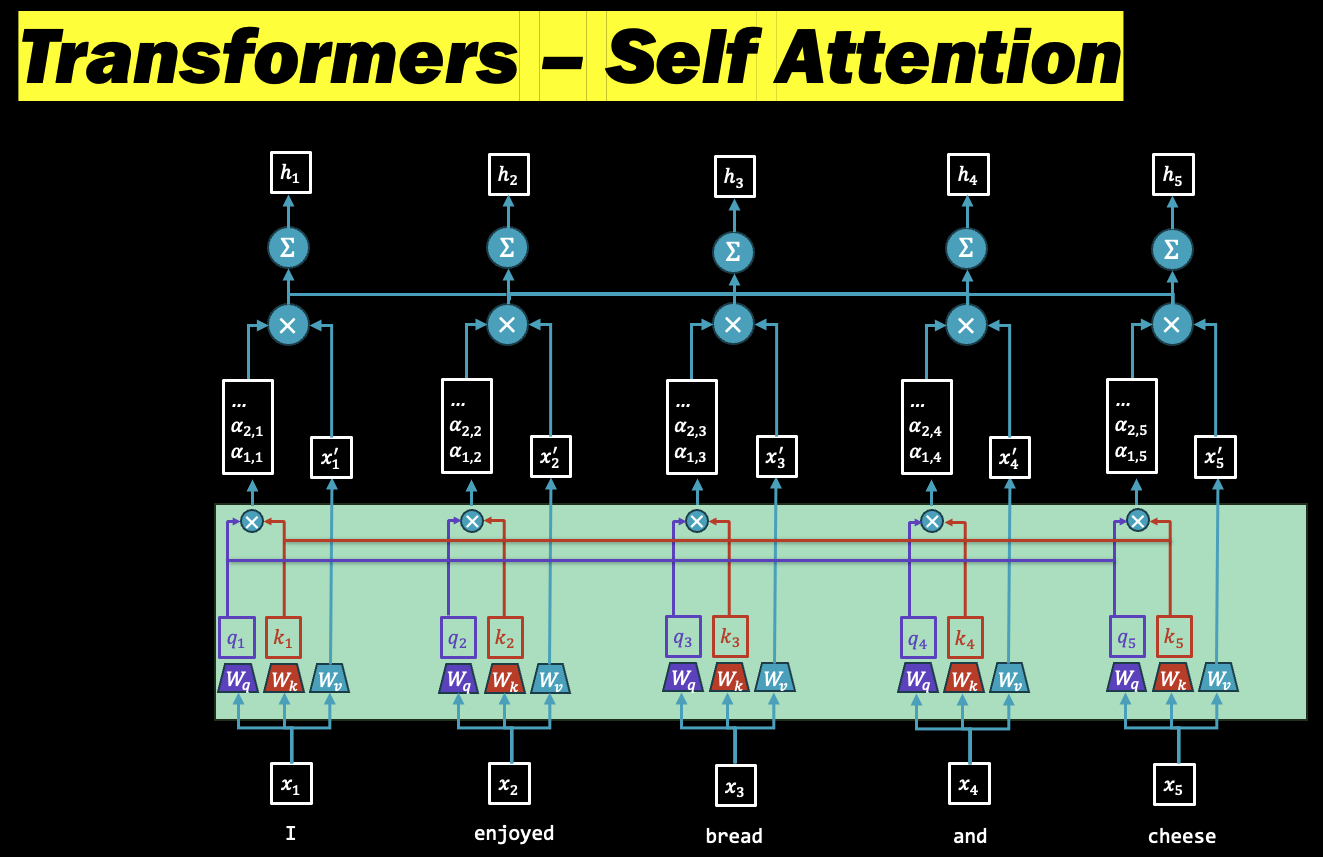

These α's should be a matrix of shape (T, T), where T is the sequence length.

Let's compute some attention!

In [ ]:
# Let's consider this simple example:
# We have batch size B=4
# Sequence length (or context length) T=8
# Token feature dimension C=3
B, T, C = 4, 8, 3

x = torch.randn(B, T, C)

print("x:")
print(x.shape)
print(x)

x:
torch.Size([4, 8, 3])
tensor([[[ 1.6095,  1.4372, -1.0256],
         [ 0.6464, -1.6309,  0.1389],
         [-0.3351,  0.1577, -0.4156],
         [ 0.4892,  0.0540, -0.4915],
         [ 0.0027,  1.6455,  0.5552],
         [ 0.6168, -0.0707,  0.7899],
         [ 1.2111, -0.7712, -0.9354],
         [ 0.6290,  0.5221, -1.0253]],

        [[-0.0364,  0.4102, -1.4345],
         [ 1.3915,  1.0269,  0.3837],
         [ 0.4484, -0.0060,  0.9348],
         [ 0.9220, -0.6403, -1.0447],
         [-0.8930, -0.6570, -0.7711],
         [-0.1362, -0.7928, -1.3390],
         [-1.4030,  0.5514, -0.0648],
         [-0.7449,  2.4740, -0.0142]],

        [[-0.3535,  0.8668,  0.4701],
         [-0.0628, -0.0762, -1.6347],
         [ 1.6837, -1.5317,  0.9779],
         [ 0.6314,  0.2687,  0.8580],
         [ 0.9968,  0.5535,  0.1065],
         [-0.5721, -0.9958, -2.3892],
         [-0.0369,  0.2691, -0.4212],
         [ 0.8428, -1.2544, -0.5049]],

        [[-0.3229,  0.6842, -0.6908],
         [ 0.2473, 

The simplest attention would be to compute an average

In [ ]:
alphas = torch.ones(T, T) / T

print("alphas:")
print(alphas.shape)
print(alphas)

alphas:
torch.Size([8, 8])
tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


In [ ]:
x_out = alphas @ x  # (T, T) @ (B, T, C)  -> (B, T, C)

print("x_out:")
print(x_out.shape)
print(x_out)

x_out:
torch.Size([4, 8, 3])
tensor([[[ 0.6087,  0.1680, -0.3012],
         [ 0.6087,  0.1680, -0.3012],
         [ 0.6087,  0.1680, -0.3012],
         [ 0.6087,  0.1680, -0.3012],
         [ 0.6087,  0.1680, -0.3012],
         [ 0.6087,  0.1680, -0.3012],
         [ 0.6087,  0.1680, -0.3012],
         [ 0.6087,  0.1680, -0.3012]],

        [[-0.0565,  0.2958, -0.4187],
         [-0.0565,  0.2958, -0.4187],
         [-0.0565,  0.2958, -0.4187],
         [-0.0565,  0.2958, -0.4187],
         [-0.0565,  0.2958, -0.4187],
         [-0.0565,  0.2958, -0.4187],
         [-0.0565,  0.2958, -0.4187],
         [-0.0565,  0.2958, -0.4187]],

        [[ 0.3912, -0.2375, -0.3172],
         [ 0.3912, -0.2375, -0.3172],
         [ 0.3912, -0.2375, -0.3172],
         [ 0.3912, -0.2375, -0.3172],
         [ 0.3912, -0.2375, -0.3172],
         [ 0.3912, -0.2375, -0.3172],
         [ 0.3912, -0.2375, -0.3172],
         [ 0.3912, -0.2375, -0.3172]],

        [[ 0.2442, -0.0038, -0.2910],
         [ 0.24

Also remember that GPT training is decoder-only, meaning that we cannot see the future tokens but only the previous ones. So we have to zero out α's in the future.

In [ ]:
alphas_decoder = torch.tril(alphas)

print("alphas_decoder:")
print(alphas_decoder.shape)
print(alphas_decoder)


alphas_decoder:
torch.Size([8, 8])
tensor([[0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1250, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.0000, 0.0000, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.0000, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


In [ ]:
alphas_decoder = alphas_decoder / alphas_decoder.sum(dim=1, keepdim=True)

print("alphas_decoder:")
print(alphas_decoder.shape)
print(alphas_decoder)

alphas_decoder:
torch.Size([8, 8])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


In [ ]:
# Now we have masked attention
x_out = alphas_decoder @ x

print("x_out:")
print(x_out.shape)
print(x_out)


x_out:
torch.Size([4, 8, 3])
tensor([[[ 1.6095,  1.4372, -1.0256],
         [ 1.1279, -0.0969, -0.4433],
         [ 0.6403, -0.0120, -0.4341],
         [ 0.6025,  0.0045, -0.4485],
         [ 0.4825,  0.3327, -0.2477],
         [ 0.5049,  0.2655, -0.0748],
         [ 0.6058,  0.1174, -0.1977],
         [ 0.6087,  0.1680, -0.3012]],

        [[-0.0364,  0.4102, -1.4345],
         [ 0.6775,  0.7186, -0.5254],
         [ 0.6011,  0.4770, -0.0387],
         [ 0.6814,  0.1977, -0.2902],
         [ 0.3665,  0.0268, -0.3864],
         [ 0.2827, -0.1098, -0.5452],
         [ 0.0419, -0.0154, -0.4765],
         [-0.0565,  0.2958, -0.4187]],

        [[-0.3535,  0.8668,  0.4701],
         [-0.2082,  0.3953, -0.5823],
         [ 0.4224, -0.2470, -0.0622],
         [ 0.4747, -0.1181,  0.1678],
         [ 0.5791,  0.0162,  0.1556],
         [ 0.3872, -0.1524, -0.2686],
         [ 0.3266, -0.0922, -0.2904],
         [ 0.3912, -0.2375, -0.3172]],

        [[-0.3229,  0.6842, -0.6908],
         [-0.03

In [ ]:
# Or, we can use the softmax function
import torch.nn.functional as F

alphas_decoder = torch.tril(torch.ones(T, T))
alphas_decoder = alphas_decoder.masked_fill(alphas_decoder == 0, float("-inf"))
alphas_decoder = F.softmax(alphas_decoder, dim=1)

print("alphas_decoder:")
print(alphas_decoder.shape)
print(alphas_decoder)



alphas_decoder:
torch.Size([8, 8])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


In [ ]:
# verify using a for loop.
x_out2 = torch.zeros(B, T, C)

for b in range(B):
    for t in range(T):
        xprev = x[b, :t + 1]
        x_out2[b, t] = torch.mean(xprev, dim=0)

print(x_out2)
print(torch.allclose(x_out, x_out2))



tensor([[[ 1.6095,  1.4372, -1.0256],
         [ 1.1279, -0.0969, -0.4433],
         [ 0.6403, -0.0120, -0.4341],
         [ 0.6025,  0.0045, -0.4485],
         [ 0.4825,  0.3327, -0.2477],
         [ 0.5049,  0.2655, -0.0748],
         [ 0.6058,  0.1174, -0.1977],
         [ 0.6087,  0.1680, -0.3012]],

        [[-0.0364,  0.4102, -1.4345],
         [ 0.6775,  0.7186, -0.5254],
         [ 0.6011,  0.4770, -0.0387],
         [ 0.6814,  0.1977, -0.2902],
         [ 0.3665,  0.0268, -0.3864],
         [ 0.2827, -0.1098, -0.5452],
         [ 0.0419, -0.0154, -0.4765],
         [-0.0565,  0.2958, -0.4187]],

        [[-0.3535,  0.8668,  0.4701],
         [-0.2082,  0.3953, -0.5823],
         [ 0.4224, -0.2470, -0.0622],
         [ 0.4747, -0.1181,  0.1678],
         [ 0.5791,  0.0162,  0.1556],
         [ 0.3872, -0.1524, -0.2686],
         [ 0.3266, -0.0922, -0.2904],
         [ 0.3912, -0.2375, -0.3172]],

        [[-0.3229,  0.6842, -0.6908],
         [-0.0378,  0.9398, -0.5293],
      

Now let's get into self attention!

In [ ]:
import torch.nn as nn

head_size = 16
key = nn.Linear(C, head_size)
query = nn.Linear(C, head_size)
value = nn.Linear(C, head_size)

k = key(x)    # B, T, 16
q = query(x)  # B, T, 16
v = value(x)  # B, T, 16

attention = q @ k.transpose(-2, -1)  # (B, T, 16) @ (B, 16, T) -> B, T, T
attention = torch.tril(attention)
attention = attention.masked_fill(attention==0, float("-inf"))
attention = F.softmax(attention, dim=-1)  # B, T, T

x_out = attention @ v  # (B, T, T) @ (B, T, 16)  --> (B, T, 16)

print("attention:")
print(attention.shape)
print(attention[0])

print("x_out:")
print(x_out.shape)
print(x_out[0])

attention:
torch.Size([4, 8, 8])
tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.2261e-03, 9.9877e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4965e-01, 5.9589e-01, 2.5445e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.9149e-02, 7.4848e-01, 8.8343e-02, 1.2403e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.6056e-01, 1.5038e-02, 2.5603e-02, 6.4491e-02, 3.4304e-02, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.5126e-01, 4.7517e-01, 1.2620e-01, 2.0211e-01, 7.6098e-03, 3.7651e-02,
         0.0000e+00, 0.0000e+00],
        [6.9910e-04, 8.0632e-01, 1.3459e-02, 1.7226e-02, 2.4279e-04, 1.4043e-02,
         1.4801e-01, 0.0000e+00],
        [2.8230e-02, 4.7109e-01, 4.0522e-02, 6.9950e-02, 9.7615e-03, 8.6299e-02,
         2.4889e-01, 4.5259e-02]], grad_fn=<SelectBackward0>)
x_out:
torch.Size([

# We are ready to build our GPT

First let's copy the important things over

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?

# read data
with open('/content/drive/MyDrive/elon_tweets_clean.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# tokenize data
class MyTokenizer():
    def __init__(self, text):
        self.text = text
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }

    def encode(self, s):
        return [self.stoi[c] for c in s]

    def decode(self, l):
        return ''.join([self.itos[i] for i in l])

tokenizer = MyTokenizer(text)

data = torch.tensor(tokenizer.encode(text))

# split train and validation data
def split_data():
    n = int(0.9*len(text))
    return data[:n], data[n:]

train_data, val_data = split_data()

# function to get minibatched data
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y


Now let's write the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class AttentionHead(nn.Module):
    def __init__(self, in_features, head_size, dropout=0.2):
        super().__init__()
        self.key = nn.Linear(in_features, head_size, bias=False)
        self.query = nn.Linear(in_features, head_size, bias=False)
        self.value = nn.Linear(in_features, head_size, bias=False)
        self.register_buffer('mask', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape

        query = self.query(x)  # B, T, hs
        key = self.key(x)      # B, T, hs
        value = self.value(x)  # B, T, hs

        attention = query @ key.transpose(-2, -1) * key.shape[-1] ** -0.5  # B, T, T
        attention = torch.tril(attention)
        attention = attention.masked_fill(attention==0, float("-inf"))
        attention = F.softmax(attention, dim=-1)

        out = attention @ value  # (B, T, T) @ (B, T, hs)  --> (B, T, hs)
        return self.dropout(out)

class MultiHeadAttention(nn.Module):
    def __init__(self, in_features, num_heads, head_size, dropout=0.2):
        super().__init__()
        self.sa_heads = nn.ModuleList([AttentionHead(in_features, head_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, in_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.sa_heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            nn.Linear(out_features, in_features),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.fc(x)


class TransformerBlock(nn.Module):
    def __init__(self, in_features, num_heads, dropout=0.2):
        super().__init__()
        head_size = in_features // num_heads
        self.mhsa = MultiHeadAttention(in_features, num_heads, head_size, dropout)
        self.ff = FeedForward(in_features, in_features * 4, dropout)
        self.norm1 = nn.LayerNorm(in_features)
        self.norm2 = nn.LayerNorm(in_features)

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.ff(self.norm2(out))
        return out


class GPT(nn.Module):
    def __init__(self, num_layers, in_features, num_heads, dropout=0.2):
        super().__init__()
        self.token_embedding_table = nn.Embedding(tokenizer.vocab_size, in_features)
        self.pos_embedding_table = nn.Embedding(block_size, in_features)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(in_features, num_heads, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(in_features)
        self.to_vocab = nn.Linear(in_features, tokenizer.vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.pos_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.transformer_blocks(x) # (B,T,C)
        x = self.norm(x) # (B,T,C)
        logits = self.to_vocab(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



In [ ]:
model = GPT(num_layers=6, in_features=384, num_heads=6, dropout=0.2).to(device)





In [ ]:
model(torch.ones((1, 1), dtype=torch.long, device=device))

(tensor([[[-0.6249, -0.2160, -0.2020,  0.6668,  0.3861,  0.4780, -0.8737,
            0.0178, -0.3528, -0.3960, -0.3978, -0.0425,  0.2534, -0.0182,
           -0.2323, -0.7897,  0.1599,  0.6745, -0.1170, -0.0579,  0.0859,
            0.2598, -0.0513, -0.2089,  0.6065, -0.2247, -0.2193,  0.4986,
           -0.2904, -0.0816, -0.3662, -0.1119,  0.3822, -0.2176,  0.1611,
            0.4448, -1.1988, -0.3022, -0.2296,  0.7079, -0.6424, -0.1768,
           -0.5570,  0.0848, -0.2736,  0.3014,  0.1740,  0.1582,  0.2188,
            0.1466, -0.4726, -0.5821,  0.2941,  0.5394,  0.4105, -0.9627,
           -0.1273,  0.5305, -0.6334,  0.3842, -0.4210, -0.3546, -0.0940,
            0.8981, -0.1841, -0.2843,  0.7013, -0.1818, -0.2039,  0.1585,
           -0.4321, -0.3046,  0.0233, -0.6696, -0.3369, -0.7160,  0.0016,
            0.2013, -0.0175, -0.2642, -0.0686,  0.3063,  0.6997,  0.6922,
            0.1623, -0.2941,  0.8568, -0.0916, -0.0185, -0.0543, -0.0657,
            0.3333,  0.1782, -0.1068, 

In [ ]:
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            X, Y = X.to(device), Y.to(device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(tokenizer.decode(model.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 5.5606, val loss 5.5610
step 500: train loss 1.7661, val loss 1.7818
step 1000: train loss 1.4655, val loss 1.4887
step 1500: train loss 1.3616, val loss 1.3975
step 2000: train loss 1.3019, val loss 1.3511
step 2500: train loss 1.2688, val loss 1.3225
step 3000: train loss 1.2345, val loss 1.2947
step 3500: train loss 1.2124, val loss 1.2799
step 4000: train loss 1.1915, val loss 1.2758
step 4500: train loss 1.1741, val loss 1.2606
step 4999: train loss 1.1561, val loss 1.2566

 and i saw many dumping your midterm in the entire. you ask off it. you are on past the chatrel. i read human behind he is critical protect with re-now is open up and sucky up the lready off trial!! you will tweet all this kinda soft elon’s try to note! same. but you have no idea to talk like stop throughout.
 hill make a democracy trade and we have no project so he did, he holder, whose he symptoms… reinstand… cry basic telegraters have a simple bitcoy. indeed.
 also i agree of hype family t

In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device) + 45
print(tokenizer.decode(model.generate(context, max_new_tokens=1500)[0].tolist()))

he knowle buy to soprant, invest in part 2022. did you release ? overthrody i can win the oilence of conce with it there. i have shadow been in history public, but an ew market people until the group and twitter user according does to physically express of the hell journalists and actually commentally, as he smarter when you do. lying about puls it lady wont, and holding him. thinking his could not like they take it and we no point, pick and notes when i know, and add for peep from coupics and all needs glip off, and; death exchange.
 banning yup on the issue. please jeals he or go descreensearch information alives. fix with no monger, …
 gp. won this, okad bc negit. prove video marxist v.m covid. promine freak of people about it now or lets their polations all office, but this the vote that same will never too win. 
 no, there’s nothing to be placed.
 what's the stuck?
 read, until an us top government natural 10,000, folid to twitter 
 but twitter's brilliant vehtbox agi guns into co

In [ ]:
tokenizer.chars

['\n',
 ' ',
 '!',
 '#',
 '$',
 '%',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 '¡',
 '£',
 '§',
 '©',
 '«',
 '®',
 '¯',
 '°',
 '´',
 '·',
 '¹',
 '»',
 '¿',
 '×',
 'à',
 'á',
 'â',
 'ä',
 'æ',
 'é',
 'ê',
 'ë',
 'ì',
 'í',
 'ï',
 'ð',
 'ñ',
 'ò',
 'ó',
 'ö',
 'ú',
 'û',
 'ü',
 'ā',
 'ă',
 'ą',
 'ğ',
 'ī',
 'į',
 'ı',
 'ō',
 'ś',
 'ə',
 'ɡ',
 'ʖ',
 'ˈ',
 'ˌ',
 '˶',
 '̇',
 '͜',
 '͡',
 'π',
 'в',
 'о',
 'п',
 'р',
 'т',
 'я',
 'ё',
 'ђ',
 'џ',
 'ґ',
 'ӿ',
 '،',
 'ا',
 'ت',
 'ر',
 'س',
 'ه',
 'و',
 'ي',
 'ِ',
 'پ',
 'ښ',
 '۱',
 '۴',
 '۸',
 '۹',
 'ध',
 'न',
 'फ',
 'म',
 'र',
 'व',
 'ि',
 'ॉ',
 'ो',
 '्',
 '૮',
 'ข',
 'ง',
 'จ',
 'ช',
 'ณ',
 'ต',
 'ท',
 'น',
 'บ',
 '